In [239]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

# Example 1

$$
y = x^2 + x + exp(x) + cos(x) * sin(x) \\
\dfrac{d}{dx} y = 2 x + 1 + exp(x) + cos(2x) \\
y \dfrac{d}{dx} y = \left ( x^2 + x + exp(x) + cos(x) \right ) \left ( 2 x + 1 + exp(x) + cos(2x) \right ) \\
y(0) = 1
$$

In [249]:
net = nn.Sequential(nn.Linear(1, 2), nn.Sigmoid(), 
                    nn.Linear(2, 1))
opt = optim.Adam(net.parameters(), lr=0.01)

dx     = 0.1
grid   = torch.arange(0, 1, dx)[:, None]
dx     = torch.tensor([dx])
errors = list()
epochs = 5000
plot   = True

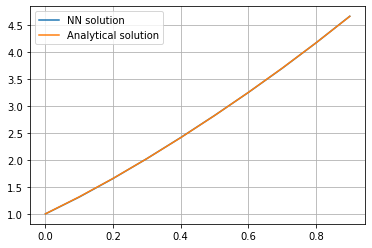

KeyboardInterrupt: 

In [250]:
for epoch in range(epochs):
    
    opt.zero_grad()
    loss = 0
    
    x_grid = grid
    x_prev, x, x_next = x_grid - dx, x_grid, x_grid + dx
    y_prev, y, y_next = net(x_prev), net(x), net(x_next)
    
    dy_dx = (y_next - y_prev) / (2 * dx)
    f = (2 * x + 1 + torch.exp(x) + torch.cos(2 * x)) * (x ** 2 + x + torch.exp(x) + torch.cos(x) * torch.sin(x))
    loss =  (y[1:] * dy_dx[1:] - f[1:]) ** 2
    loss += (net(grid[0]) - 1) ** 2
    
    loss = loss.mean()
    
    loss.backward()
    opt.step()
    
    errors += [loss.item()]
    
    if plot and epoch % 1000 == 0 and epoch > 0:
        
        clear_output()
        X = x.detach().numpy()
        Y = y.detach().numpy()
        
        plt.plot(X, Y, label='NN solution')
        plt.plot(X, X ** 2 + X  + np.exp(X) + np.cos(X) * np.sin(X), label='Analytical solution')
        
        plt.legend()
        plt.grid()
        
        plt.show()

# Example 2

$$
u = x + y^2 + exp(x) + cos(2 y) \\
\dfrac{\partial}{\partial x} u = 1 + exp(x) \\
\dfrac{\partial}{\partial y} u = 2 y - 2 sin(2 y) \\
u(0, y) = y^2 + cos(2 y) + 1 \\
u(1, y) = 1 + y^2 + cos(2 y) + e \\
u(x, 0) = x + exp(x) + 1 \\
u(x, 1) = x + 1 + exp(x) + cos(2) \\
\dfrac{\partial}{\partial y} u + \dfrac{\partial}{\partial x} u = 1 + exp(x) + 2 y - 2 sin(2 y)
$$

In [513]:
net = nn.Sequential(nn.Linear(2, 3), nn.Sigmoid(),
                    nn.Linear(3, 3), nn.Sigmoid(),
                    nn.Linear(3, 1))
opt = optim.Adadelta(net.parameters(), lr=0.05)

dx, dy = 0.1, 0.1
errors = list()
epochs = 2500
plot   = True

In [514]:
x, y = torch.arange(0, 1 + dx / 2, dx), torch.arange(0, 1 + dy / 2, dy)
X, Y = torch.meshgrid(x, y)

In [515]:
x_bound_0 = torch.stack((X[0].flatten(), Y[0].flatten())).transpose(1, 0)
x_bound_1 = torch.stack((X[-1].flatten(), Y[0].flatten())).transpose(1, 0)
y_bound_0 = torch.stack((X[:, 0].flatten(), Y[:, 0].flatten())).transpose(1, 0)
y_bound_1 = torch.stack((X[:, 0].flatten(), Y[:, -1].flatten())).transpose(1, 0)
inner_grd = torch.stack((X[1:-1, 1:-1].flatten(), Y[1:-1, 1:-1].flatten())).transpose(1, 0)

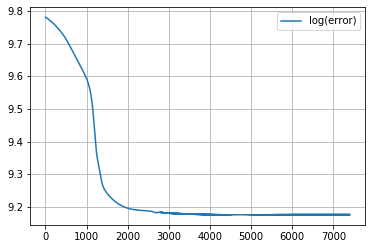

In [518]:
for epoch in range(epochs):
    
    opt.zero_grad()
    loss = 0
    DX, DY = torch.tensor([dx, 0]), torch.tensor([0, dy])
    
    u_x_bound_0, u_x_bound_1, u_y_bound_0, u_y_bound_1 = net(x_bound_0), net(x_bound_1), net(y_bound_0), net(y_bound_1)
    
    loss += ((u_x_bound_0 - (x_bound_0[:, 1] ** 2 + torch.cos(2 * x_bound_0[:, 1]) + 1)) ** 2).sum()
    loss += ((u_x_bound_1 - (1 + x_bound_0[:, 1] ** 2 + torch.cos(2 * x_bound_0[:, 1]) + torch.exp(torch.tensor([1.0])))) ** 2).sum()
    loss += ((u_y_bound_0 - (y_bound_0[:, 0] + torch.exp(y_bound_0[:, 0]) + torch.tensor([1.0]))) ** 2).sum()
    loss += ((u_y_bound_1 - (y_bound_1[:, 0] + torch.exp(y_bound_1[:, 0]) + torch.tensor([1.0]) + torch.cos(torch.tensor([2.0])))) ** 2).sum()
    
    inner_x_prev, inner_x_cur, inner_x_next = inner_grd - DX, inner_grd, inner_grd + DX
    inner_y_prev, inner_y_cur, inner_y_next = inner_grd - DY, inner_grd, inner_grd + DY
    
    u_inner_x_prev, u_inner_x_cur, u_inner_x_next = net(inner_x_prev), net(inner_x_cur), net(inner_x_next)
    u_inner_y_prev, u_inner_y_cur, u_inner_y_next = net(inner_y_prev), net(inner_y_cur), net(inner_y_next)
    
    du_dx = (u_inner_x_next - 2 * u_inner_x_cur + u_inner_x_prev) / (dx ** 2)
    du_dy = (u_inner_y_next - 2 * u_inner_y_cur + u_inner_y_prev) / (dy ** 2)
    
    loss += ((du_dx + du_dy - (2 + torch.exp(inner_x_cur[:, 0]) - 4 * torch.sin(2 * inner_x_cur[:, 1]))) ** 2).sum()
    
    loss.backward()
    opt.step()
    
    errors += [loss.item()]
    
    if plot and epoch % 100 == 0 and epoch > 0:
        
        clear_output()
        
        plt.plot(np.log(errors), label='log(error)')
        
        plt.legend()
        plt.grid()
        
        plt.show()

In [519]:
x_bound_0

tensor([[0.0000, 0.0000],
        [0.0000, 0.1000],
        [0.0000, 0.2000],
        [0.0000, 0.3000],
        [0.0000, 0.4000],
        [0.0000, 0.5000],
        [0.0000, 0.6000],
        [0.0000, 0.7000],
        [0.0000, 0.8000],
        [0.0000, 0.9000],
        [0.0000, 1.0000]])

In [520]:
u_x_bound_0

tensor([[2.8150],
        [2.8121],
        [2.8093],
        [2.8066],
        [2.8041],
        [2.8016],
        [2.7993],
        [2.7971],
        [2.7949],
        [2.7929],
        [2.7910]], grad_fn=<AddmmBackward>)

In [521]:
x_bound_0[:, 1] ** 2 + torch.cos(2 * x_bound_0[:, 1]) + 1

tensor([2.0000, 1.9901, 1.9611, 1.9153, 1.8567, 1.7903, 1.7224, 1.6600, 1.6108,
        1.5828, 1.5839])

In [481]:
torch.cos(2 * x_bound_0[:, 1])

tensor([ 1.0000,  0.9801,  0.9211,  0.8253,  0.6967,  0.5403,  0.3624,  0.1700,
        -0.0292, -0.2272, -0.4161])